In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, BaggingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.feature_selection import SelectKBest, f_regression

In [2]:
train = pd.read_csv('Train.csv')
train.head()

,AI Usage Rate (%),AI Content Volume (TB/year),AI Job Displacement (%),AI Revenue Growth (%),AI Company Share (%),AI Trust Level (%)
0,92.8687,32.0427,28.3327,73.1526,23.4880,42.8667
1,87.9504,22.7819,31.5425,17.1596,30.0360,33.6239
2,58.8744,59.1192,41.4354,24.3215,24.2937,76.0753
3,21.3525,66.7059,29.1964,49.3291,46.1369,75.4762
4,82.5507,53.1270,17.2975,52.8736,6.4636,77.8699


In [3]:
train.shape

(13224, 6)

In [4]:
train.isnull().sum()

AI Usage Rate (%)              0
AI Content Volume (TB/year)    0
AI Job Displacement (%)        0
AI Revenue Growth (%)          0
AI Company Share (%)           0
AI Trust Level (%)             0
dtype: int64

In [5]:
train.duplicated().sum()

0

In [6]:
train.describe()

,AI Usage Rate (%),AI Content Volume (TB/year),AI Job Displacement (%),AI Revenue Growth (%),AI Company Share (%),AI Trust Level (%)
count,13224.000000,13224.000000,13224.000000,13224.000000,13224.000000,13224.000000
mean,54.599830,46.573490,25.587164,40.185837,26.301977,59.606411
std,23.781708,28.870014,13.551123,23.402734,13.820715,17.022335
min,11.152200,1.047600,0.092900,0.140900,1.180000,30.129900
25%,34.027625,20.504600,15.129900,18.851725,14.060100,45.179175
50%,53.174150,45.112600,25.671250,42.750850,26.948550,59.478350
75%,76.125225,71.902475,37.112475,59.387675,38.272250,74.708225
max,94.731800,99.050700,49.708500,79.549500,49.279900,89.880000


In [7]:
test = pd.read_csv('Test.csv')
test.head()

,AI Usage Rate (%),AI Content Volume (TB/year),AI Job Displacement (%),AI Revenue Growth (%),AI Company Share (%),AI Trust Level (%)
0,38.2724,77.1922,48.0387,74.6022,13.9205,NaN
1,46.0732,5.1294,10.2898,64.8858,20.4068,NaN
2,26.1318,37.3251,32.5000,67.5758,43.1477,NaN
3,25.9315,43.2346,27.0721,61.8256,47.5778,NaN
4,66.4651,56.9111,47.9087,10.2990,10.8309,NaN


In [8]:
test.shape

(300, 6)

In [9]:
test.isnull().sum()

AI Usage Rate (%)                0
AI Content Volume (TB/year)      0
AI Job Displacement (%)          0
AI Revenue Growth (%)            0
AI Company Share (%)             0
AI Trust Level (%)             300
dtype: int64

In [10]:
test.duplicated().sum()

0

In [11]:
combined = pd.concat([train, test], axis = 0)
combined.shape

(13524, 6)

C:\Users\ahpat\AppData\Local\Temp\ipykernel_8900\3525261229.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['AI Trust Level (%)'], kde = True)


<Axes: xlabel='AI Trust Level (%)', ylabel='Density'>

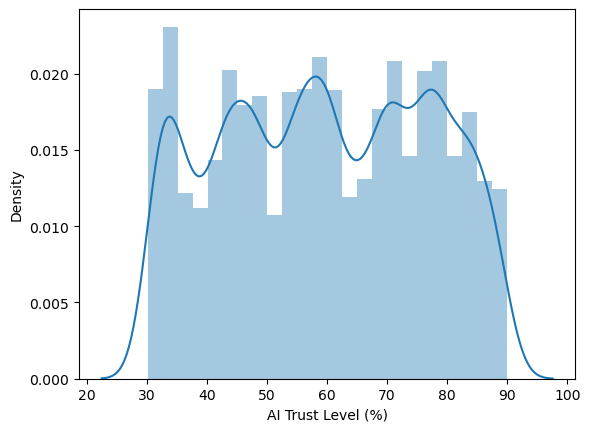

In [12]:
sns.distplot(train['AI Trust Level (%)'], kde = True)

In [13]:
input_variables = combined.drop('AI Trust Level (%)', axis = 1)

In [14]:
def replace_outliers(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3-q1
    lower = q1-1.5*iqr
    upper = q3+1.5*iqr
    median_value = df[column].median()
    df[column] = np.where((df[column]<lower)|(df[column]>upper), median_value, df[column])
    return df

In [15]:
for col in input_variables.columns:
    concat_df = replace_outliers(combined, col)

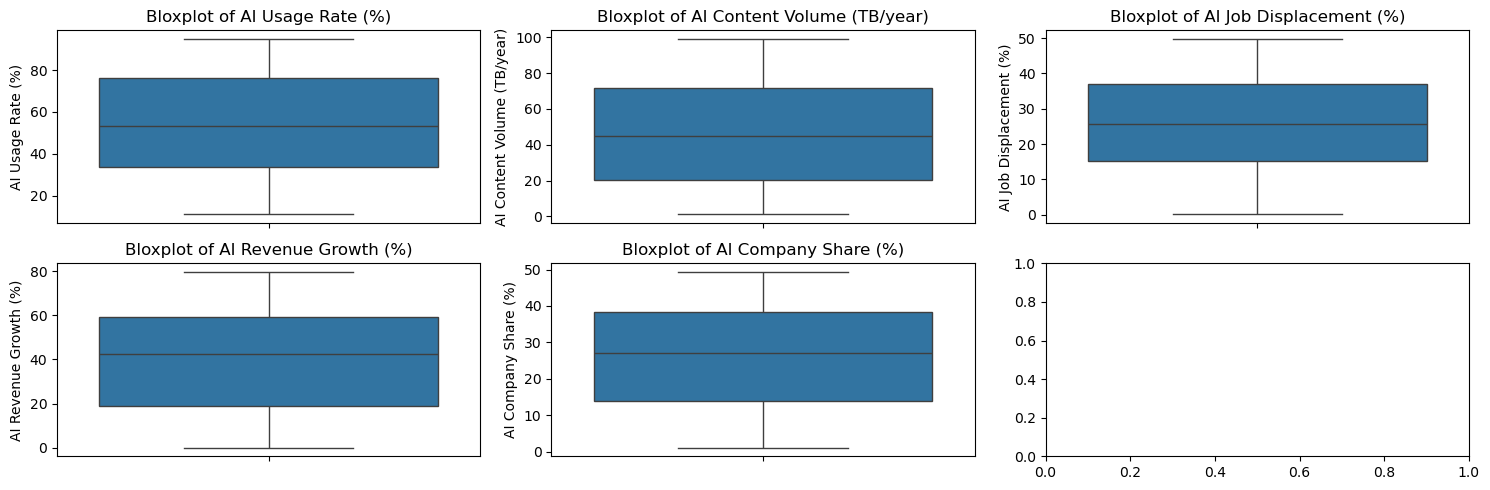

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(15,5))
axes = axes.flatten()

for i, col in enumerate(input_variables.columns):
    sns.boxplot(data = combined, y=col, ax=axes[i])
    axes[i].set_title(f'Bloxplot of {col}')

plt.tight_layout()
plt.show()

In [17]:
combined['usage_revenue'] = combined['AI Usage Rate (%)'] * combined['AI Revenue Growth (%)']
combined['usage_company'] = combined['AI Usage Rate (%)'] * combined['AI Company Share (%)']
combined['displacement_usage'] = combined['AI Job Displacement (%)'] * combined['AI Usage Rate (%)']
combined['displacement_revenue'] = combined['AI Job Displacement (%)'] / (combined['AI Revenue Growth (%)'] + 1e-5)
combined['content_usage'] = combined['AI Content Volume (TB/year)'] / (combined['AI Usage Rate (%)'] + 1e-5)
combined['total_impact'] = combined[['AI Usage Rate (%)', 'AI Job Displacement (%)', 'AI Revenue Growth (%)']].sum(axis=1)
combined['market_influence'] = combined['AI Usage Rate (%)'] + combined['AI Company Share (%)']
combined['disruption_index'] = combined['AI Job Displacement (%)'] + combined['AI Content Volume (TB/year)']
combined['max_input'] = combined[['AI Usage Rate (%)', 'AI Content Volume (TB/year)', 'AI Job Displacement (%)', 'AI Revenue Growth (%)', 'AI Company Share (%)']].max(axis=1)
combined['min_input'] = combined[['AI Usage Rate (%)', 'AI Content Volume (TB/year)', 'AI Job Displacement (%)', 'AI Revenue Growth (%)', 'AI Company Share (%)']].min(axis=1)
combined['mean_input'] = combined[['AI Usage Rate (%)', 'AI Content Volume (TB/year)', 'AI Job Displacement (%)', 'AI Revenue Growth (%)', 'AI Company Share (%)']].mean(axis=1)
combined['std_input'] = combined[['AI Usage Rate (%)', 'AI Content Volume (TB/year)', 'AI Job Displacement (%)', 'AI Revenue Growth (%)', 'AI Company Share (%)']].std(axis=1)
combined['adoption_disruption'] = combined['AI Usage Rate (%)'] / (combined['AI Job Displacement (%)'] + 1e-5)
combined['content_efficiency'] = combined['AI Content Volume (TB/year)'] / (combined['AI Usage Rate (%)'] + 1e-5)
combined['revenue_per_share'] = combined['AI Revenue Growth (%)'] / (combined['AI Company Share (%)'] + 1e-5)
combined['log_content_volume'] = np.log(combined['AI Content Volume (TB/year)'] + 1)
combined['log_revenue_growth'] = np.log(combined['AI Revenue Growth (%)'] + 1)
combined['log_displacement'] = np.log(combined['AI Job Displacement (%)'] + 1)

In [18]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13524 entries, 0 to 299
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   AI Usage Rate (%)            13524 non-null  float64
 1   AI Content Volume (TB/year)  13524 non-null  float64
 2   AI Job Displacement (%)      13524 non-null  float64
 3   AI Revenue Growth (%)        13524 non-null  float64
 4   AI Company Share (%)         13524 non-null  float64
 5   AI Trust Level (%)           13224 non-null  float64
 6   usage_revenue                13524 non-null  float64
 7   usage_company                13524 non-null  float64
 8   displacement_usage           13524 non-null  float64
 9   displacement_revenue         13524 non-null  float64
 10  content_usage                13524 non-null  float64
 11  total_impact                 13524 non-null  float64
 12  market_influence             13524 non-null  float64
 13  disruption_index       

In [19]:
newtrain = combined.iloc[0:13224, :]
newtest = combined.iloc[13224:, :].drop('AI Trust Level (%)', axis = 1)

In [20]:
newtrain.head()

,AI Usage Rate (%),AI Content Volume (TB/year),AI Job Displacement (%),AI Revenue Growth (%),AI Company Share (%),AI Trust Level (%),usage_revenue,usage_company,displacement_usage,displacement_revenue,...,max_input,min_input,mean_input,std_input,adoption_disruption,content_efficiency,revenue_per_share,log_content_volume,log_revenue_growth,log_displacement
0,92.8687,32.0427,28.3327,73.1526,23.4880,42.8667,6793.586864,2181.300026,2631.221016,0.387309,...,92.8687,23.4880,49.97694,31.098988,3.277791,0.345032,3.114466,3.497801,4.306125,3.378703
1,87.9504,22.7819,31.5425,17.1596,30.0360,33.6239,1509.193684,2641.678214,2774.175492,1.838183,...,87.9504,17.1596,37.89408,28.574568,2.788313,0.259031,0.571301,3.168925,2.899199,3.482547
2,58.8744,59.1192,41.4354,24.3215,24.2937,76.0753,1431.913720,1430.277011,2439.484314,1.703652,...,59.1192,24.2937,41.60884,17.345090,1.420872,1.004158,1.001144,4.096329,3.231654,3.747983
3,21.3525,66.7059,29.1964,49.3291,46.1369,75.4762,1053.299608,985.138157,623.416131,0.591870,...,66.7059,21.3525,42.54416,17.818404,0.731340,3.124031,1.069190,4.215173,3.918583,3.407723
4,82.5507,53.1270,17.2975,52.8736,6.4636,77.8699,4364.752692,533.574705,1427.920733,0.327148,...,82.5507,6.4636,42.46248,30.652832,4.772404,0.643568,8.180197,3.991333,3.986641,2.906764


In [21]:
newtrain.shape

(13224, 24)

In [22]:
newtest.shape

(300, 23)

In [23]:
X = newtrain.drop(columns=['AI Trust Level (%)'])
y = newtrain['AI Trust Level (%)']
k = 12  
selector = SelectKBest(score_func=f_regression, k=k)
selector.fit(X, y)
mask = selector.get_support()
selected_features = X.columns[mask]
print(f"Top {k} selected features:")
print(selected_features)

Top 12 selected features:
Index(['AI Usage Rate (%)', 'AI Content Volume (TB/year)',
       'AI Company Share (%)', 'usage_revenue', 'usage_company',
       'displacement_usage', 'total_impact', 'market_influence',
       'disruption_index', 'max_input', 'adoption_disruption',
       'revenue_per_share'],
      dtype='object')


In [24]:
correlation_matrix = newtrain.corr()
target_corr = correlation_matrix["AI Trust Level (%)"].sort_values(ascending=False)
print(target_corr)

AI Trust Level (%)             1.000000
usage_company                  0.009943
market_influence               0.006275
AI Company Share (%)           0.005495
AI Usage Rate (%)              0.004063
total_impact                   0.002750
displacement_usage             0.002441
usage_revenue                  0.002427
displacement_revenue           0.002100
mean_input                     0.002088
AI Job Displacement (%)        0.000512
log_displacement              -0.000100
AI Revenue Growth (%)         -0.000168
std_input                     -0.000241
log_content_volume            -0.001339
content_usage                 -0.001750
content_efficiency            -0.001750
min_input                     -0.001931
log_revenue_growth            -0.002027
disruption_index              -0.002135
max_input                     -0.002147
AI Content Volume (TB/year)   -0.002584
adoption_disruption           -0.010568
revenue_per_share             -0.016390
Name: AI Trust Level (%), dtype: float64

In [121]:
x = newtrain[['usage_company', 'usage_revenue', 'AI Company Share (%)', 'AI Usage Rate (%)', 'AI Content Volume (TB/year)']]
y = newtrain['AI Trust Level (%)']

In [123]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1)

In [125]:
models = {'Linear Regression': LinearRegression(), 'Random Forest': RandomForestRegressor(),
         'Bagging': BaggingRegressor(), 'Extra Tree': ExtraTreesRegressor(), 'LightGBM': LGBMRegressor(),
         'Gradient Boosting': GradientBoostingRegressor(), 'Adaboost': AdaBoostRegressor(),
         'XGB': XGBRegressor(), 'lasso': Lasso(), 'ridge' : Ridge()}

In [127]:
def evaluate_models(x_train, x_test, y_train, y_test, models):
    results = {}
    for name, model in models.items():
        predictions = model.fit(x_train, y_train).predict(x_test)
        accuracy = r2_score(y_test, predictions)
        results[name] = accuracy
    return results

In [129]:
results = evaluate_models(x_train, x_test, y_train, y_test, models)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001154 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 10579, number of used features: 5
[LightGBM] [Info] Start training from score 59.593909


In [130]:
best_model_name = max(results, key = results.get)
best_model = models[best_model_name]

In [131]:
print(f"best model is {best_model_name} with r2_square {results[best_model_name]}")

best model is Adaboost with r2_square 0.00022465429129114867


In [132]:
y_pred = best_model.fit(x_train, y_train).predict(x_test)

In [133]:
print(r2_score(y_test, y_pred))

-0.010014893848586892


In [134]:
x_train = newtrain[['usage_company', 'usage_revenue', 'AI Company Share (%)', 'AI Usage Rate (%)', 'AI Content Volume (TB/year)']]
y_train = newtrain['AI Trust Level (%)']
x_test = newtest[['usage_company', 'usage_revenue', 'AI Company Share (%)', 'AI Usage Rate (%)', 'AI Content Volume (TB/year)']]
y_pred = best_model.fit(x_train, y_train).predict(x_test)

In [141]:
solution = pd.DataFrame({'AI Trust Level (%)': y_pred})
solution.head()

,AI Trust Level (%)
0,59.607449
1,59.469550
2,59.607449
3,59.469550
4,59.607449


In [143]:
solution.to_csv('Solution.csv', index = False)